#MNIST data classification using Logistic Regression with SGDClassifier

In [ ]:
import numpy as np
import os
import io
import warnings

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, log_loss
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV
from pprint import pprint

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.stats import loguniform
np.random.seed(42)

#global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

In [ ]:
#Ignore all warnings
def warn(*args, **kwargs):
  pass
warnings.warn = warn

#Handwritten Digit Classification
* First, we consider this as a binary classification

In [ ]:
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X_pd.to_numpy()
y = y_pd.to_numpy()

##Preprocessing
* Unlike Perceptron, where scaling range is optional(but recommended), sigmoid requires scaling the features between 0 to 1
* Do not apply mean centering as it removes zeroes from the data. However, zeros should be zeros in the dataset.
* Since we are using only one preprocessing, pipeline may not be required.

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print('Mean of the values: ', np.mean(X))
print('Standard Deviation of the values: ', np.std(X))
print('Minimum of the values: ', np.min(X))
print('Maximum of the values: ', np.max(X))

Mean of the values:  0.13092720382627604
Standard Deviation of the values:  0.3084510570135976
Minimum of the values:  0.0
Maximum of the values:  1.0


In [ ]:
target_names = np.unique(y)
print('Number of samples and features: ', X.shape)
print('Number of classes: ', len(target_names))
print('Labels: ', target_names)

Number of samples and features:  (70000, 784)
Number of classes:  10
Labels:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


##Data Visualization

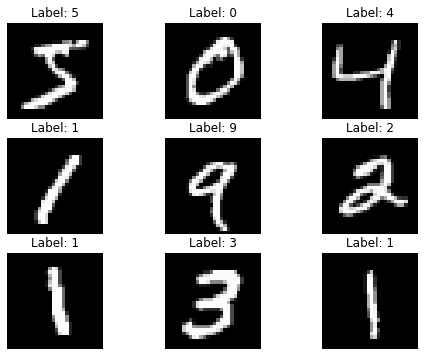

In [ ]:
num_images = 9
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+ i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label: {0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

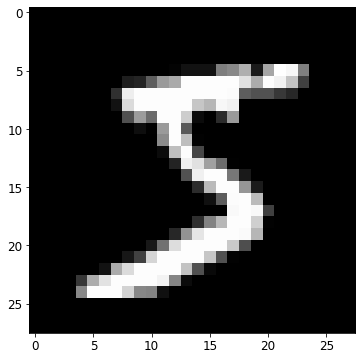

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.show()

##Data Splitting

In [ ]:
X_train, X_test, y_train, y_test  = X[:60000], X[60000:], y[:60000], y[60000:]

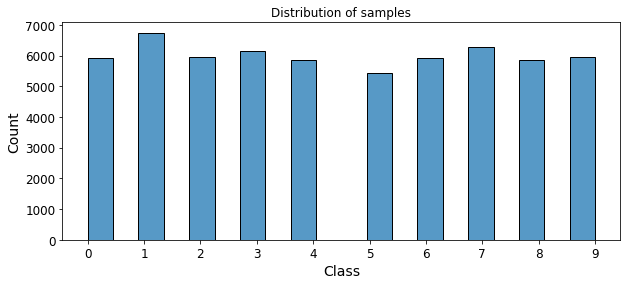

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

#Binary Classification - 0 Detection


In [ ]:
y_train_0 = -1 * np.ones((len(y_train)))
y_test_0 = -1 * np.ones((len(y_test)))

#find the indices of digit 0
indx_0 = np.where(y_train == '0') # oroginal labels are str, not int
#use these indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1 
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

Sanity check

In [ ]:
print(y_train)
print(y_train_0)

print(np.where(y_train == '0'))
print(np.where(y_train_0 == 1))

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


##Baseline Model
1. Count the no of samples per class
2. The model always output the class which has the highest no of samples.
3. Then calculate the accuracy of the baseline model.

In [ ]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])
print(num_pos, num_neg)

5923 54077


In [ ]:
base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(X_train, y_train_0)
print('training accuracy: ', base_clf.score(X_train, y_train_0))
print('test accuracy: ', base_clf.score(X_test, y_test_0))

training accuracy:  0.9012833333333333
test accuracy:  0.902


##Logistic Regression Model

* Setting the loss parameter of SGDClassifier to **'loss=log'** makes it a logistic regression classifier. 

##Training without regularization
* set eta0=0.01, learning_rate='constant' and alpha=0

In [ ]:
bin_sgd_clf = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729
                            )
loss = []
iterations=100
for i in range(iterations):
  bin_sgd_clf.fit(X_train, y_train_0)
  y_pred = bin_sgd_clf.predict_proba(X_train)
  loss.append(log_loss(y_train_0, y_pred))

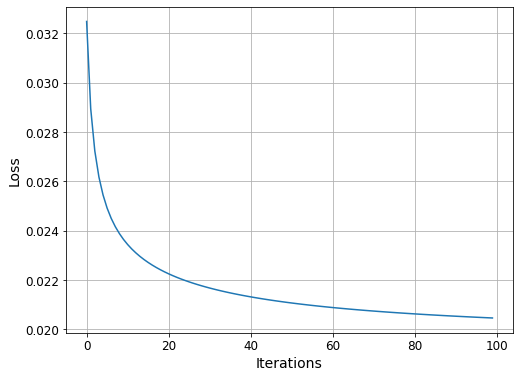

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
print('Training accuracy: ', bin_sgd_clf.score(X_train, y_train_0))
print('Testing accuracy: ', bin_sgd_clf.score(X_test, y_test_0))

Training accuracy:  0.99395
Testing accuracy:  0.9919


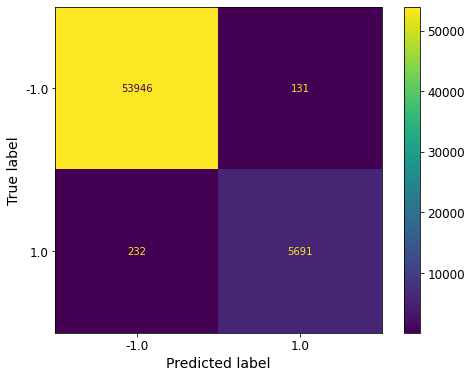

In [ ]:
y_hat_train_0 = bin_sgd_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')

In [ ]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



Do cross validation to check the generalization ability of the model

In [ ]:
estimator = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=100,
                            warm_start=False,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729
                            )

In [ ]:
cv_bin_clf = cross_validate(estimator,
                            X_train,
                            y_train_0,
                            cv=5,
                            scoring=['precision', 'recall', 'f1'],
                            return_train_score=True,
                            return_estimator=True
                            )

pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729)],
 'fit_time': array([2.07859397, 1.4143703 , 1.40387845, 1.55925655, 1.26441145]),
 'score_time': array([0.06231546, 0.04205203, 0.04016495, 0.04032159, 0.04160905]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.9

* From this we can see that Logistic regression is better than Perceptron

In [ ]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_
print('Dimension of weight: ', weights.shape)
print('Bias: ', bias)

Dimension of weight:  (1, 784)
Bias:  [-4.89282893]


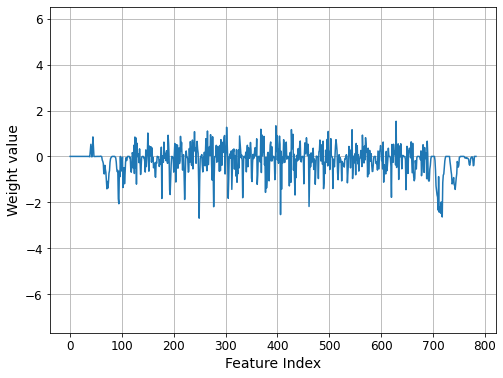

In [ ]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel('Feature Index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid()

* Observe that many weight values are exactly zero.
* Those features contribute nothing to the classification

In [ ]:
num_zero_w = weights.shape[1] - np.count_nonzero(weights)
print('Number of weights with value Zero: ', num_zero_w)

Number of weights with value Zero:  67


From the above plot, **it is also obvious that regularization is not required.**

##Training with regularization
* What happens to the performance of the model if we penalize, out of temptation, the weight values even to a small degree.

In [ ]:
bin_sgd_clf_l2 = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0.001,
                            learning_rate='constant',
                            random_state=1729
                            )
loss = []
iterations=100
for i in range(iterations):
  bin_sgd_clf_l2.fit(X_train, y_train_0)
  y_pred = bin_sgd_clf_l2.predict_proba(X_train)
  loss.append(log_loss(y_train_0, y_pred))

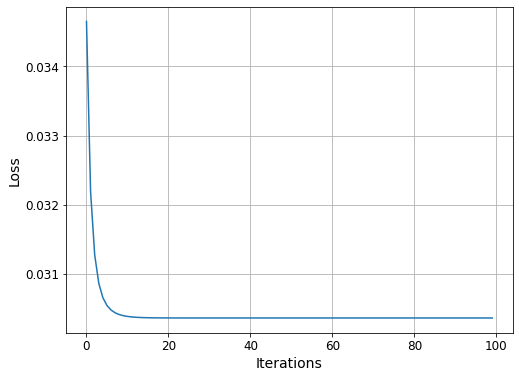

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_
print('Dimension of weight: ', weights.shape)
print('Bias: ', bias)

Dimension of weight:  (1, 784)
Bias:  [-4.43002876]


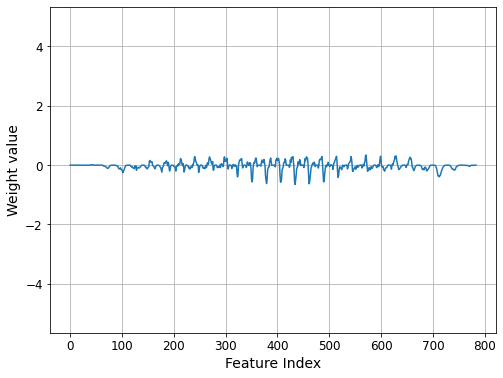

In [ ]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel('Feature Index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid()

In [ ]:
num_zero_w = weights.shape[1] - np.count_nonzero(weights)
print('Number of weights with value Zero: ', num_zero_w)

Number of weights with value Zero:  67


In [ ]:
print('Training accuracy: ', bin_sgd_clf_l2.score(X_train, y_train_0))
print('Testing accuracy: ', bin_sgd_clf_l2.score(X_test, y_test_0))

Training accuracy:  0.9907166666666667
Testing accuracy:  0.9905


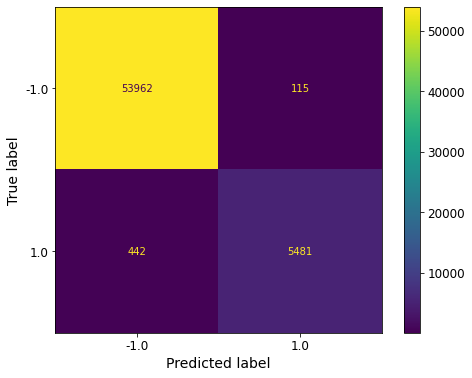

In [ ]:
y_hat_train_0 = bin_sgd_clf_l2.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')

In [ ]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



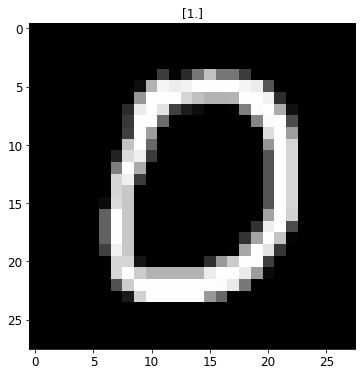

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(X_test[10,:].reshape(28,28), cmap='gray')
pred = bin_sgd_clf.predict(X_test[10].reshape(1,-1))
plt.title(str(pred))
plt.show()

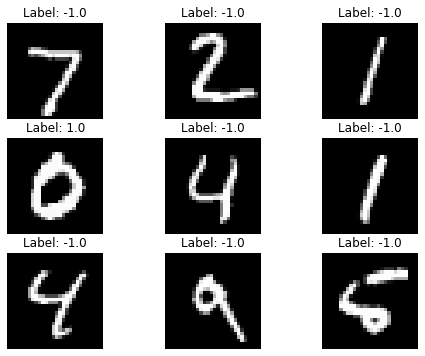

In [ ]:
y_hat_test_0 = bin_sgd_clf.predict(X_test)
num_images = 9
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+ i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X_test[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label: {0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

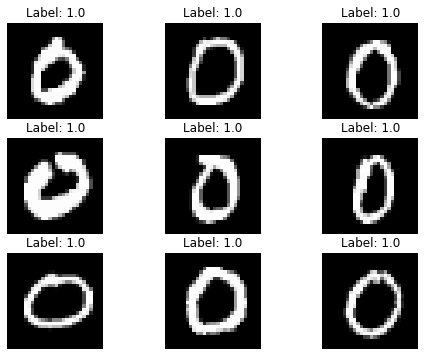

In [ ]:
index_0 = np.where(y_test_0 == 1)
zeroImgs = X_test[index_0[0]]
zeroLabs = y_hat_test_0[index_0[0]]
num_images = 9
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+ i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label: {0}'.format(str(zeroLabs[index+j])))
    ax[i,j].set_axis_off()

##HyperParameter Tuning
* We have to use cross-validation folds and measure the same metrics across these folds for different values of hyperparameters. 
* Logistic regression uses SGD solver and hence the learning rate and regularization rate are two important hyperparameters. 

In [ ]:
lr_grid = loguniform(1e-2, 1e-2)

* Note that lr_grid is an object that contains a method called rvs() which can bw used to get the samples of given size.
* Therefor we pass lr_grid object to RandomizedSearchCV. Internally it makes use of rvs() method for sampling.

In [ ]:
print(lr_grid.rvs(1, random_state=42))

ValueError: ignored

In [ ]:
estimator = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729
                            )

In [ ]:
scores = RandomizedSearchCV(estimator,
                            param_distributions={'eta0': lr_grid},
                            cv=5,
                            scoring=['precision', 'recall', 'f1'],
                            n_iter=5,
                            refit='f1'
                            )

In [ ]:
scores.fit(X_train, y_train_0)

pprint(scores.cv_results_)

ValueError: ignored

In [ ]:
best_bin_clf = scores.best_estimator_

AttributeError: ignored

In [ ]:
y_hat_train_best_0 = best_bin_clf.predict(X_train)

print(classification_report(y_train_0, y_hat_train_best_0))

NameError: ignored

##Classification Report

###Precision Recall Tradeoff

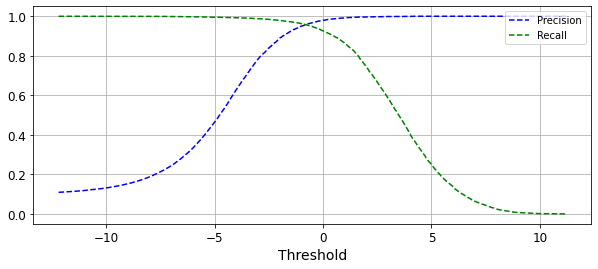

In [ ]:
y_scores = bin_sgd_clf.decision_function(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
plt.plot(thresholds, recalls[:-1], "g--", label='Recall')
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

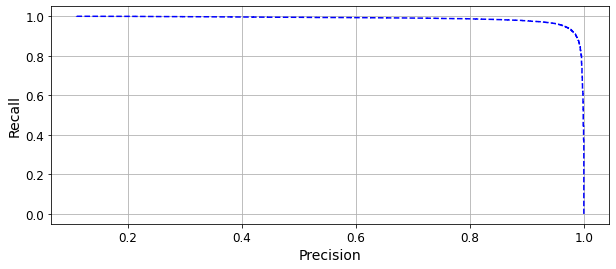

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(precisions[:-1], recalls[:-1], "b--")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

*ROC Curve

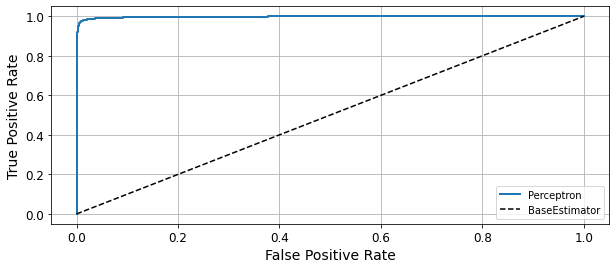

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label='Perceptron')
plt.plot([0,1], [0, 1], 'k--', label='BaseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
auc = roc_auc_score(y_train_0, y_scores)
print('AUC: ', auc)

AUC:  0.9974243304137789
